In [6]:
import sys
import os
sys.path.append(os.path.abspath(".."))
import torch
from models.change_classifier import ChangeClassifier
model = ChangeClassifier(weights=None)
state_dict = torch.load("../pretrained_models/model_46.pth", map_location="cpu", weights_only=True)
model.load_state_dict(state_dict)
model.eval()
torch.save(model.state_dict(), "../pretrained_models/model_entire.pth")

In [57]:
import matplotlib.pyplot as plt

plt.rcParams.update({
    "font.family": "Cambria",  # or "Arial", "Times New Roman", etc.
    "font.size": 28,
    "axes.titlesize": 28,
    "axes.labelsize": 28,
    "xtick.labelsize": 28,
    "ytick.labelsize": 28,
    "legend.fontsize": 28
})


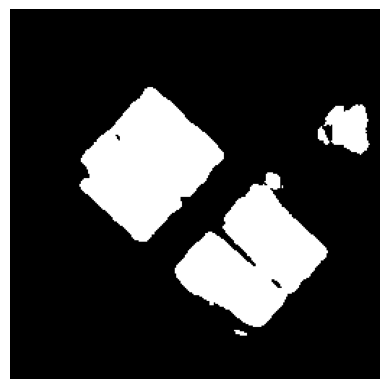

In [28]:
import torch
import matplotlib.pyplot as plt
from torchvision.transforms import Compose, Normalize, ToTensor, Resize
from PIL import Image
from models.change_classifier import ChangeClassifier
transform = Compose([
    ToTensor(),
    Normalize(  mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225])
])
img_t1 = Image.open("../sample_img/A.png").convert("RGB")
img_t2 = Image.open("../sample_img/B.png").convert("RGB")
img_t1 = transform(img_t1).unsqueeze(0)
img_t2 = transform(img_t2).unsqueeze(0)
model = ChangeClassifier()
model.load_state_dict(torch.load("../pretrained_models/model_46.pth", map_location="cpu", weights_only=True))
model.eval()
with torch.no_grad():
    out = model(img_t1, img_t2)
mask = torch.sigmoid(out)[0, 0]
mask = (mask > 0.6).float()
plt.imshow(mask, cmap="gray")
plt.axis("off")
# plt.title("Predicted Change Mask")
plt.show()

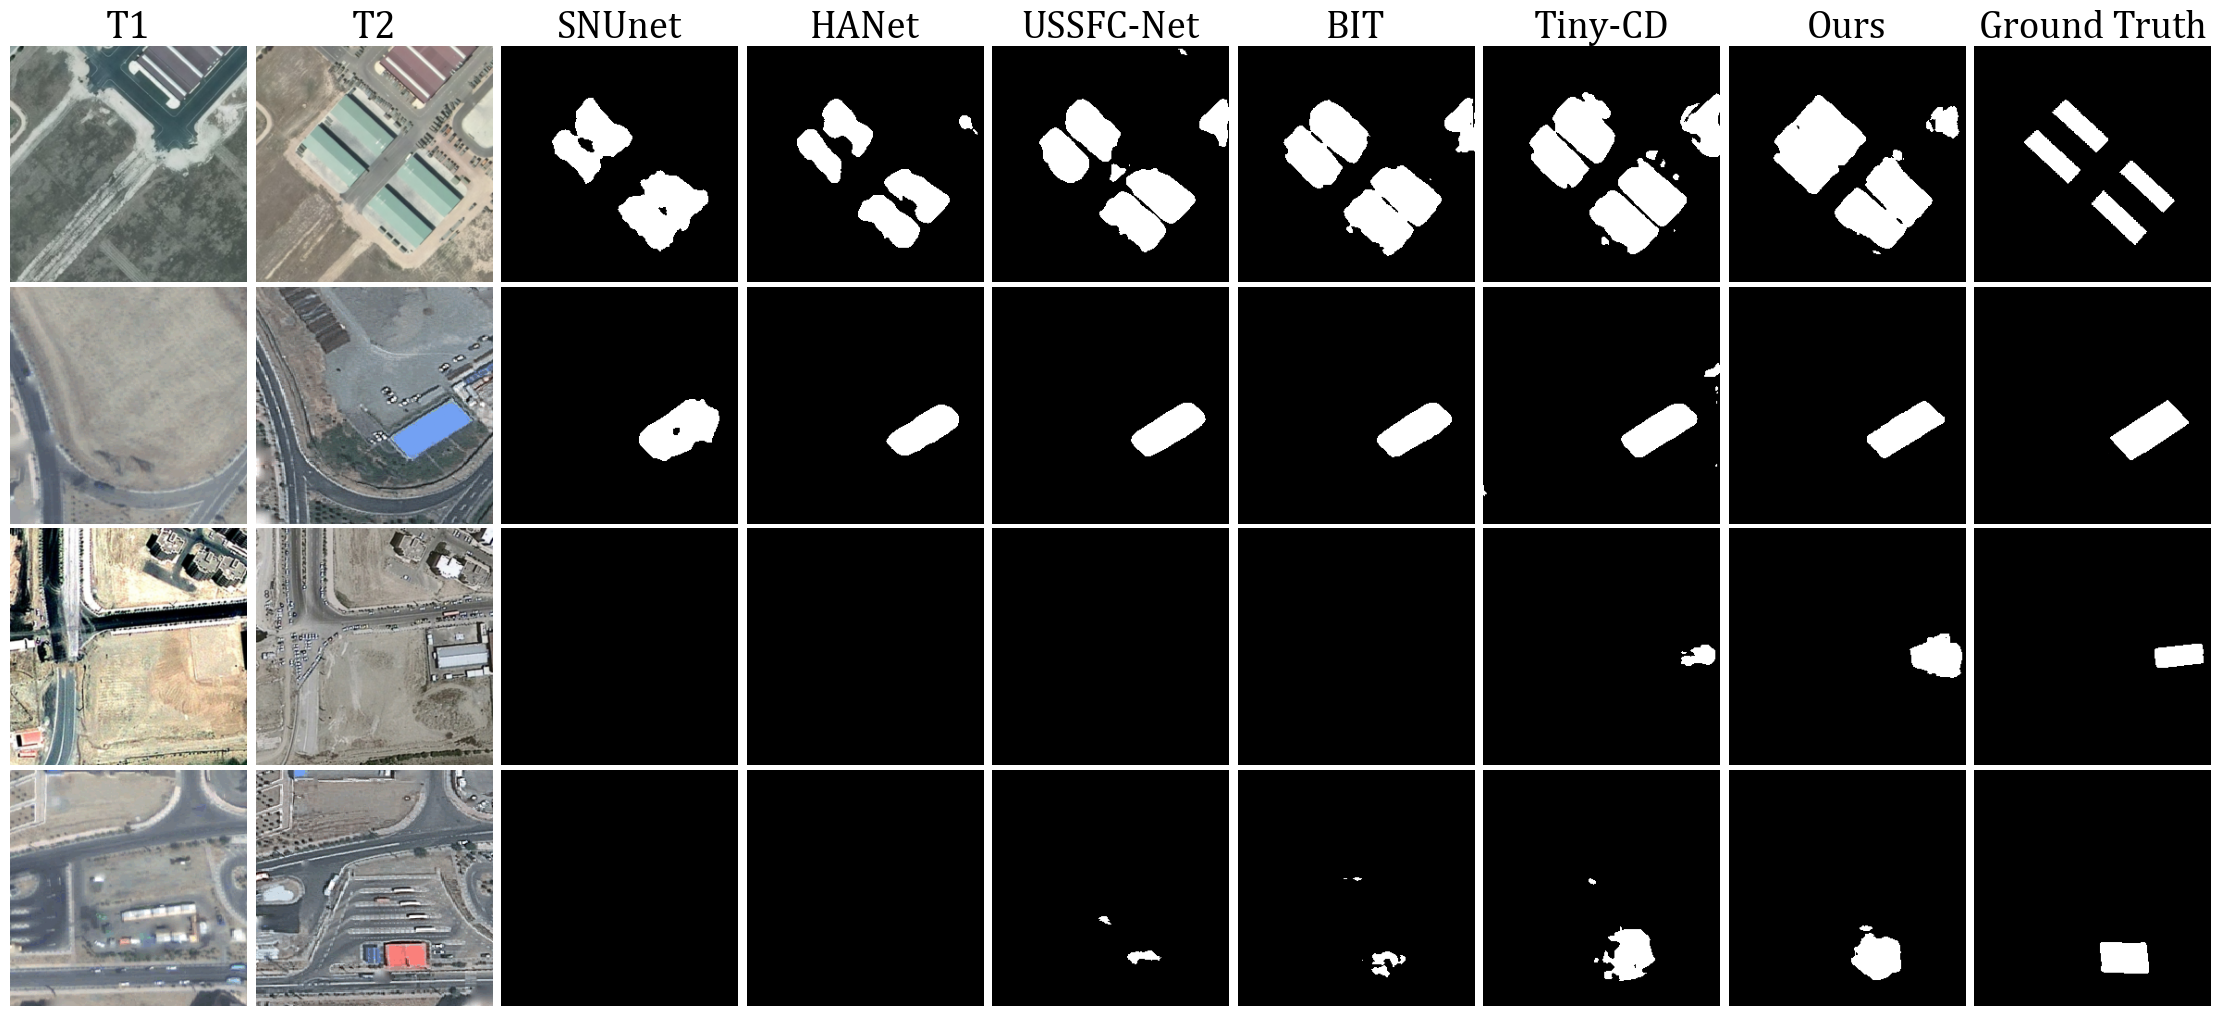

In [58]:
import torch
import matplotlib.pyplot as plt
from torchvision.transforms import Compose, Normalize, ToTensor
from PIL import Image
from models.change_classifier import ChangeClassifier

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

transform = Compose([
    ToTensor(),
    Normalize(mean=[0.485, 0.456, 0.406],
              std=[0.229, 0.224, 0.225])
])

raw_to_tensor = ToTensor()  # for displaying RGB input without normalization

def load_img_pair(t1_path, t2_path):
    t1_raw = raw_to_tensor(Image.open(t1_path).convert("RGB"))
    t2_raw = raw_to_tensor(Image.open(t2_path).convert("RGB"))
    t1 = transform(Image.open(t1_path).convert("RGB")).unsqueeze(0).to(device)
    t2 = transform(Image.open(t2_path).convert("RGB")).unsqueeze(0).to(device)
    return t1, t2, t1_raw, t2_raw

def load_mask(path):
    return ToTensor()(Image.open(path).convert("L"))[0].to(device)

def predict(model, t1, t2):
    model.eval()
    with torch.no_grad():
        out = model(t1, t2)
    mask = torch.sigmoid(out)[0, 0]
    return (mask > 0.6).float().cpu()

model_ids = [0, 1, 2, 3, 4, 46]
model_names = [
    "SNUnet", "HANet", "USSFC-Net", "BIT", "Tiny-CD", "Ours"
]
model_paths = [f"../pretrained_models/model_{i}.pth" for i in model_ids]

models = []
for path in model_paths:
    m = ChangeClassifier().to(device)
    m.load_state_dict(torch.load(path, map_location=device, weights_only=True))
    models.append(m)

pairs = [
    {"t1": "../sample_img/A.png", "t2": "../sample_img/B.png", "label": "../sample_img/label1.png"},
    {"t1": "../sample_img/C.png", "t2": "../sample_img/D.png", "label": "../sample_img/label2.png"},
    {"t1": "../sample_img/E.png", "t2": "../sample_img/F.png", "label": "../sample_img/label3.png"},
    {"t1": "../sample_img/G.png", "t2": "../sample_img/H.png", "label": "../sample_img/label4.png"}
]

num_cols = len(models) + 3  # T1 + T2 + all models + GT
fig, axs = plt.subplots(nrows=4, ncols=num_cols, figsize=(2.5*num_cols, 10))

for row_idx, pair in enumerate(pairs):
    t1, t2, t1_raw, t2_raw = load_img_pair(pair["t1"], pair["t2"])

    axs[row_idx, 0].imshow(t1_raw.permute(1, 2, 0))
    axs[row_idx, 0].axis("off")
    if row_idx == 0:
        axs[row_idx, 0].set_title("T1")

    axs[row_idx, 1].imshow(t2_raw.permute(1, 2, 0))
    axs[row_idx, 1].axis("off")
    if row_idx == 0:
        axs[row_idx, 1].set_title("T2")

    for col_idx, model in enumerate(models):
        pred = predict(model, t1, t2)
        axs[row_idx, col_idx + 2].imshow(pred, cmap="gray")
        axs[row_idx, col_idx + 2].axis("off")
        if row_idx == 0:
            axs[row_idx, col_idx + 2].set_title(model_names[col_idx])

    label = load_mask(pair["label"]).cpu()
    axs[row_idx, -1].imshow(label, cmap="gray")
    axs[row_idx, -1].axis("off")
    if row_idx == 0:
        axs[row_idx, -1].set_title("Ground Truth")

fig.subplots_adjust(left=0.01, right=0.99, top=0.98, bottom=0.02, wspace=0.02, hspace=0.02)
plt.savefig("../results/model_comparison_results.png", dpi=300, bbox_inches="tight")
plt.show()

In [ ]:
for name, module in model.named_modules():
    print(name)

In [ ]:
state_dict = torch.load("../pretrained_models/model_47.pth", map_location="cpu", weights_only=True)
# for k, v in state_dict.items():
#    if len(v.shape) == 4:  # Conv weight tensors
#        print(f"{k}: {v.shape}")
#print("all")
for k, v in state_dict.items():
    print(f"{k}: {v.shape}")

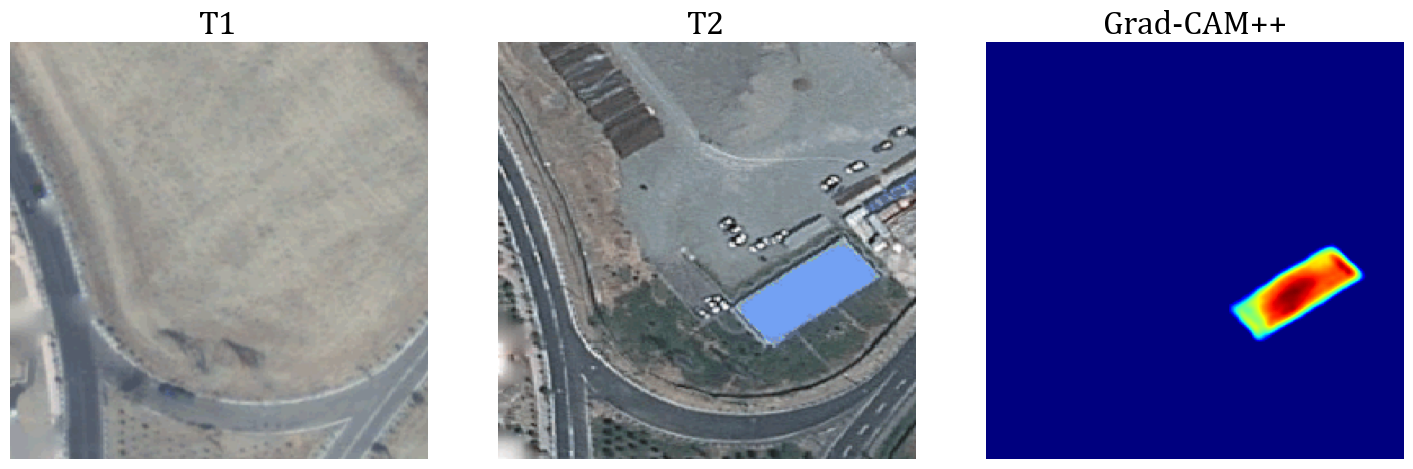

In [29]:
from torchvision.transforms import Compose, Normalize, ToTensor, Resize
from PIL import Image
import torch
from torchcam.methods import GradCAM
import matplotlib.pyplot as plt
import numpy as np
import os
from matplotlib import cm
target_layer = '_classify._linears.2.0' 
class OneInputWrapper(torch.nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model
    def forward(self, x):
        t1, t2 = x[:, :3, :, :], x[:, 3:, :, :]
        return self.model(t1, t2)
wrapped_model = OneInputWrapper(model)
wrapped_model.eval()
img_t1 = Image.open('../sample_img/C.png').convert('RGB')
img_t2 = Image.open('../sample_img/D.png').convert('RGB')
transform = Compose([
    ToTensor(),
    Normalize(mean=[0.485, 0.456, 0.406],
              std=[0.229, 0.224, 0.225])
])
input_t1 = transform(img_t1).unsqueeze(0)
input_t2 = transform(img_t2).unsqueeze(0)
input_cat = torch.cat([input_t1, input_t2], dim=1)
cam_extractor = GradCAM(model, target_layer)
output = wrapped_model(input_cat)
class_idx = 0
activation_map = cam_extractor(class_idx, output.squeeze(1))
heatmap = activation_map[0].cpu().numpy()
heatmap = np.squeeze(heatmap)
heatmap = (heatmap - heatmap.min()) / (heatmap.max() - heatmap.min() + 1e-8)
colored_heatmap = cm.jet(heatmap)[:, :, :3]
colored_heatmap = (colored_heatmap * 255).astype(np.uint8)
colored_heatmap_pil = Image.fromarray(colored_heatmap)
os.makedirs("../GradCAMpp_outputs", exist_ok=True)
safe_name = target_layer.replace('.', '_').replace('/', '_')
colored_heatmap_pil.save(f"../GradCAMpp_outputs/{safe_name}.png")
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].imshow(img_t1)
axs[0].set_title("T1")
axs[0].axis('off')
axs[1].imshow(img_t2)
axs[1].set_title("T2")
axs[1].axis('off')
axs[2].imshow(heatmap, cmap='jet')
axs[2].set_title("Grad-CAM++")
axs[2].axis('off')
plt.tight_layout()
plt.show()


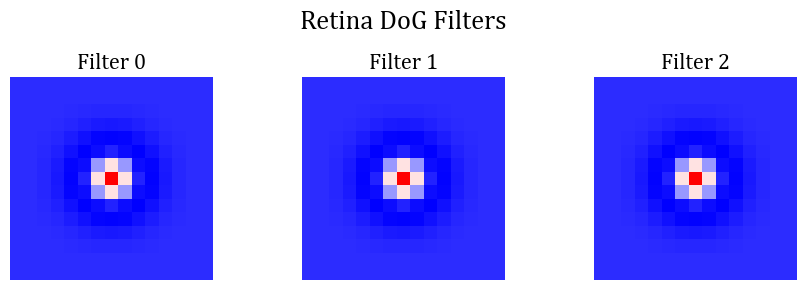

In [56]:
import torch
import matplotlib.pyplot as plt

plt.rcParams['font.family'] = 'cambria'  # or 'Arial', 'DejaVu Sans', etc.

def plot_dog_filters(filters, title="Retina DoG Filters"):
    filters = filters.detach().cpu()
    n_filters = filters.shape[0]
    fig, axs = plt.subplots(1, n_filters, figsize=(3 * n_filters, 3))
    for i in range(n_filters):
        dog = filters[i, 0]  # depthwise: one channel per conv
        axs[i].imshow(dog, cmap='bwr')  # diverging colormap shows +/-
        axs[i].set_title(f"Filter {i}")
        axs[i].axis('off')
    plt.suptitle(title)
    plt.subplots_adjust(wspace=0.9, hspace=0.1)
    plt.tight_layout()
    plt.show()

from models.change_classifier import ChangeClassifier
model = ChangeClassifier(weights=None)
dog_filters = model._retina.dog.weight.clone()
plot_dog_filters(dog_filters)


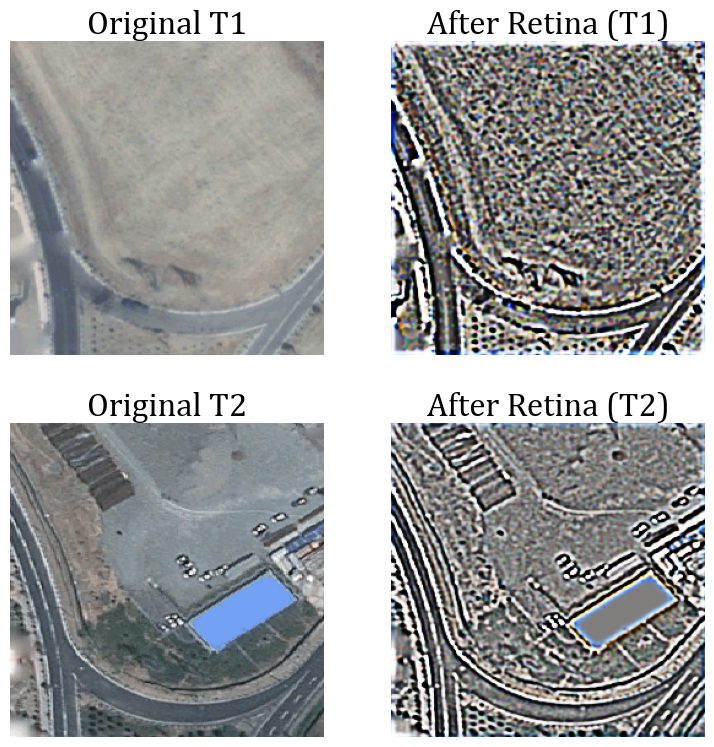

In [32]:
import torch
from torchvision.transforms import Compose, Normalize, ToTensor, Resize, ToPILImage
from PIL import Image
import matplotlib.pyplot as plt
from models.change_classifier import ChangeClassifier
model = ChangeClassifier(weights=None)
retina = model._retina.eval()
img_t1 = Image.open("../sample_img/C.png").convert("RGB")
img_t2 = Image.open("../sample_img/D.png").convert("RGB")
transform = Compose([
    ToTensor(),
    Normalize(  mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225])
])
x1 = transform(img_t1).unsqueeze(0)
x2 = transform(img_t2).unsqueeze(0)
with torch.no_grad():
    retina_out1 = retina(x1)  # shape [1, 3, 256, 256]
    retina_out2 = retina(x2)
def normalize(t):
    t = t.squeeze(0)
    t = (t - t.min()) / (t.max() - t.min() + 1e-5)
    return t
out1 = ToPILImage()(normalize(retina_out1.cpu()))
out2 = ToPILImage()(normalize(retina_out2.cpu()))
fig, axs = plt.subplots(2, 2, figsize=(8, 8))
axs[0, 0].imshow(img_t1)
axs[0, 0].set_title("Original T1")
axs[0, 1].imshow(out1)
axs[0, 1].set_title("After Retina (T1)")
axs[1, 0].imshow(img_t2)
axs[1, 0].set_title("Original T2")
axs[1, 1].imshow(out2)
axs[1, 1].set_title("After Retina (T2)")
for ax in axs.flat:
    ax.axis("off")
plt.tight_layout()
plt.show()